In [2]:
import numpy as np 
import pandas as pd
import time 
import timeit
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from scipy import interpolate
import matplotlib.pyplot as plt

In [3]:
dataset = pd.read_csv("dati_LS.csv")
display(dataset)

,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS,TIME,DETECTOR,LAYER
0,13.0,1.897417e+09,445.0,24.0,11145.000000,3.0,4.0
1,14.0,1.897417e+09,450.0,9.0,11257.500000,3.0,2.0
2,16.0,1.897417e+09,452.0,17.0,11314.166667,3.0,1.0
3,139.0,1.897417e+09,454.0,0.0,11350.000000,0.0,0.0
4,15.0,1.897417e+09,458.0,9.0,11457.500000,3.0,3.0
...,...,...,...,...,...,...,...
122821,55.0,1.920940e+09,325.0,4.0,8128.333333,3.0,3.0
122822,56.0,1.920940e+09,327.0,22.0,8193.333333,3.0,1.0
122823,139.0,1.920940e+09,329.0,0.0,8225.000000,0.0,0.0
122824,54.0,1.920940e+09,331.0,20.0,8291.666667,3.0,2.0


In [4]:
#ho notato che calcolando direttamente il drift time ci vuole più del doppio del tempo. In questa versione del documento non includo la funzione originale, se serve ce l'ho salvata localmente
df = dataset.copy()
df["TIME_PEDESTAL"] = np.nan

def assign_time_pedestal(group) :
    t0 = group["TIME"][group.DETECTOR == 0].values #senza il values non funziona perché lavora con serie anziché con strutture di numpy (non so bene perché le serie non vadano)
    group["TIME_PEDESTAL"][group.DETECTOR != 0] = t0
    return group

df = df.groupby(['ORBIT_CNT'],group_keys=False)\
                     .apply(assign_time_pedestal)\
                     .reset_index()\
                     .drop(['index'],axis=1) #niente dropna per non perdere i trigger

df["DRIFT_TIME"] = np.abs(df.TIME.values - df.TIME_PEDESTAL)
df["HOR_AMBIG_COORD"] = 42/(2*390)*df.DRIFT_TIME
df

,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS,TIME,DETECTOR,LAYER,TIME_PEDESTAL,DRIFT_TIME,HOR_AMBIG_COORD
0,13.0,1.897417e+09,445.0,24.0,11145.000000,3.0,4.0,11350.0,205.000000,11.038462
1,14.0,1.897417e+09,450.0,9.0,11257.500000,3.0,2.0,11350.0,92.500000,4.980769
2,16.0,1.897417e+09,452.0,17.0,11314.166667,3.0,1.0,11350.0,35.833333,1.929487
3,139.0,1.897417e+09,454.0,0.0,11350.000000,0.0,0.0,NaN,NaN,NaN
4,15.0,1.897417e+09,458.0,9.0,11457.500000,3.0,3.0,11350.0,107.500000,5.788462
...,...,...,...,...,...,...,...,...,...,...
122821,55.0,1.920940e+09,325.0,4.0,8128.333333,3.0,3.0,8225.0,96.666667,5.205128
122822,56.0,1.920940e+09,327.0,22.0,8193.333333,3.0,1.0,8225.0,31.666667,1.705128
122823,139.0,1.920940e+09,329.0,0.0,8225.000000,0.0,0.0,NaN,NaN,NaN
122824,54.0,1.920940e+09,331.0,20.0,8291.666667,3.0,2.0,8225.0,66.666667,3.589744


In [5]:
#scarto al volo quelli con drift times troppo grandi
Tmax = 390
experimental_time_uncertainty = 25 
T = Tmax + experimental_time_uncertainty
df = df[df.DRIFT_TIME < T]
print("max drift time:",df.DRIFT_TIME.max())

max drift time: 414.16666666666674


La funzione seguente calcola in modo vettorizzato ed efficiente la colonna "COLUMN", che rappresenta il numero (compreso fra 1 e 16) associato alla cella del layer opportuno del "rettangolo" in cui si trova un dato hit. Per contare le boxes in modo tradizionale bisogna eliminare la convenzione strana di default, il che impone un conteggio layer dependent. In ogni layer da una box a quella immediatamente a destra TDC_CHANNEL salta di +4 unità; pertanto se i TDC_CHANNEL delle boxes consecutive in un fissato layer sono x1,x2,...,x16 dividendo per 4 possiamo mappare la successione `[x1,x2,...,x16]` in quella voluta `[1,2,...,16]` a meno di resto - dovuto al fatto che solo un layer contiene multipli di 4. Per compensare questo resto possiamo sommare/sottrarre un valore layer dependent al TDC_CHANNEL in modo da costruire multipli di 4, dopodiché se dividiamo per 4 e castiamo a intero (in modo di fatto da approssimare per difetto) otteniamo `[0,1,...,15]`, che con un +1 diventa l'intervallo voluto. In questo modo si costruisce la corretta mappa layer dependent dalla successione iniziale a quella voluta (da 1 a 16).  
`BarycentricInterpolator([x1,x2,x3,x4],[y1,y2,y3,y4])` è una interpolazione che dà il polinomio che attraversa i punti `[x1,y1]` eccetera; valutata su layer (cioè proprio in corrispondenza di `[x1,x2,x3,x4]`=`[1,2,3,4]`) ci restituisce i valori layer dependent che ci servono in quanto stiamo valutando il polinomio proprio nei punti utilizzati per costruirlo. Questa operazione è vettorizzata, efficiente e analoga al dic_replace visto nel documento precedente.  
Ovviamente è comodo ricondurre l'intervallo `[65,128]` a quello `[1,64]` in quanto i TDC_CHANNEL che superano 64 lo fanno solo perché si riferiscono ad un altro detector (ma la geometria della mappa discussa finora è la stessa)

In [6]:
#add column coordinate of the cell
def minus64(x):
    #if x <= 64:
    if x < 65:
        return x
    else:
        return x - 64
    
df['COLUMN'] = ((df['TDC_CHANNEL'].apply(minus64)
                   - interpolate.BarycentricInterpolator([1,2,3,4],[1,3,2,4])(df['LAYER'])) / 4 + 1).astype(int)

df

,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS,TIME,DETECTOR,LAYER,TIME_PEDESTAL,DRIFT_TIME,HOR_AMBIG_COORD,COLUMN
0,13.0,1.897417e+09,445.0,24.0,11145.000000,3.0,4.0,11350.0,205.000000,11.038462,3
1,14.0,1.897417e+09,450.0,9.0,11257.500000,3.0,2.0,11350.0,92.500000,4.980769,3
2,16.0,1.897417e+09,452.0,17.0,11314.166667,3.0,1.0,11350.0,35.833333,1.929487,4
4,15.0,1.897417e+09,458.0,9.0,11457.500000,3.0,3.0,11350.0,107.500000,5.788462,4
5,89.0,1.897417e+09,300.0,27.0,7522.500000,2.0,4.0,7825.0,302.500000,16.288462,6
...,...,...,...,...,...,...,...,...,...,...,...
122820,19.0,1.920940e+09,1449.0,2.0,36226.666667,3.0,3.0,36075.0,151.666667,8.166667,5
122821,55.0,1.920940e+09,325.0,4.0,8128.333333,3.0,3.0,8225.0,96.666667,5.205128,14
122822,56.0,1.920940e+09,327.0,22.0,8193.333333,3.0,1.0,8225.0,31.666667,1.705128,14
122824,54.0,1.920940e+09,331.0,20.0,8291.666667,3.0,2.0,8225.0,66.666667,3.589744,13


In [7]:
#%timeit df['COLUMN'] = ((df['TDC_CHANNEL'].apply(minus64) - interpolate.BarycentricInterpolator([1,2,3,4],[1,3,2,4])(df['LAYER'])) / 4 + 1).astype(int)
#38.7 ms ± 480 µs per loop (mean ± std. dev. of 7 runs, 10 loops each) con il <=, 37.9 ms ± 525 µs per loop (mean ± std. dev. of 7 runs, 10 loops each) con il <

In [15]:
#preso paro paro da Mattia
def event_plot(event):
    
    fig,ax1 = plt.subplots(figsize=(1.5*4.2*17,1.5*1.3*6))
    
    #dimensions of cells
    dx=42
    dy=13
    
    x = []
    y = []
    for i in range(len(event)):
        hit = event.iloc[i]
        y1 = dy * (4 - hit.LAYER + 1/2)
        y.append(y1)
        y.append(y1)
        if hit.LAYER%2 == 0:0
            x1 = dx * (hit.COLUMN - 1/2) + hit.X 
            x2 = dx * (hit.COLUMN - 1/2) - hit.X 
            x.append(x1)
            x.append(x2)
        else:
            x1 = dx * hit.COLUMN + hit.X 
            x2 = dx * hit.COLUMN - hit.X 
            x.append(x1)
            x.append(x2)
            

    #draw the detector
    ax1.set_xlim(0,42*16 + 42)
    ax1.set_ylim(-13,13*4 + 13)


    #coordinates of layer 4
    x_1 = np.arange(1,17)*42-dx
    y_1 = 0
    
    #coordinates of layer 3
    x_2 = x_1 + dx/2
    y_2 = dy
    
    #coordinates of layer 2
    x_3 = x_1
    y_3 = 2*dy
    
    #coordinates of layer 1
    x_4 = x_2
    y_4 = 3*dy
    
    for i in range(16):
        rect = patches.Rectangle((x_1[i],y_1),dx,dy,linewidth=10,edgecolor='black',facecolor='none')
        ax1.add_patch(rect)
    
        rect = patches.Rectangle((x_2[i],y_2),dx,dy,linewidth=10,edgecolor='black',facecolor='none')
        ax1.add_patch(rect)
    
        rect = patches.Rectangle((x_3[i],y_3),dx,dy,linewidth=10,edgecolor='black',facecolor='none')
        ax1.add_patch(rect)
        
        rect = patches.Rectangle((x_4[i],y_4),dx,dy,linewidth=10,edgecolor='black',facecolor='none')
        ax1.add_patch(rect)
        
        ax1.axis('off')
        
    ax1.scatter(x,y, marker = 'x', c = 'red', s = 500, linewidth = 7)
    return ax1

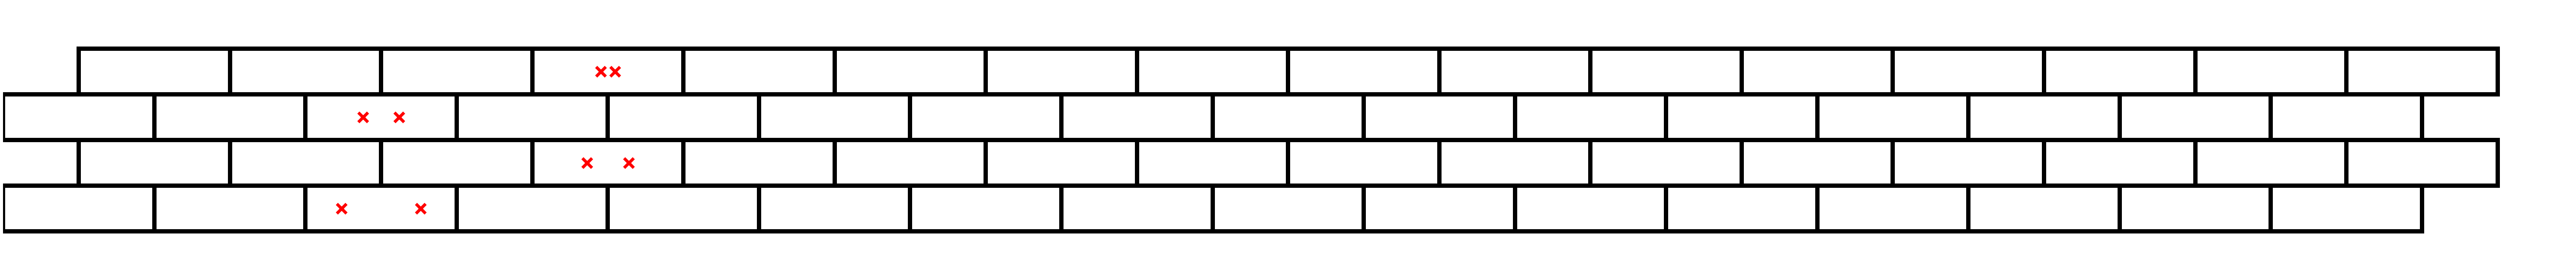

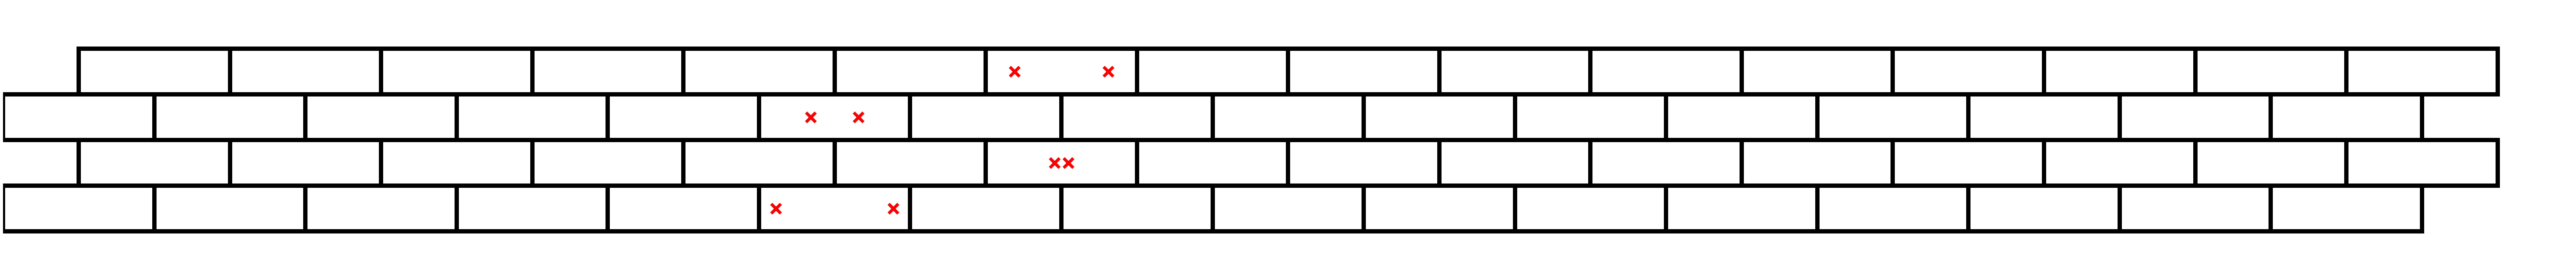

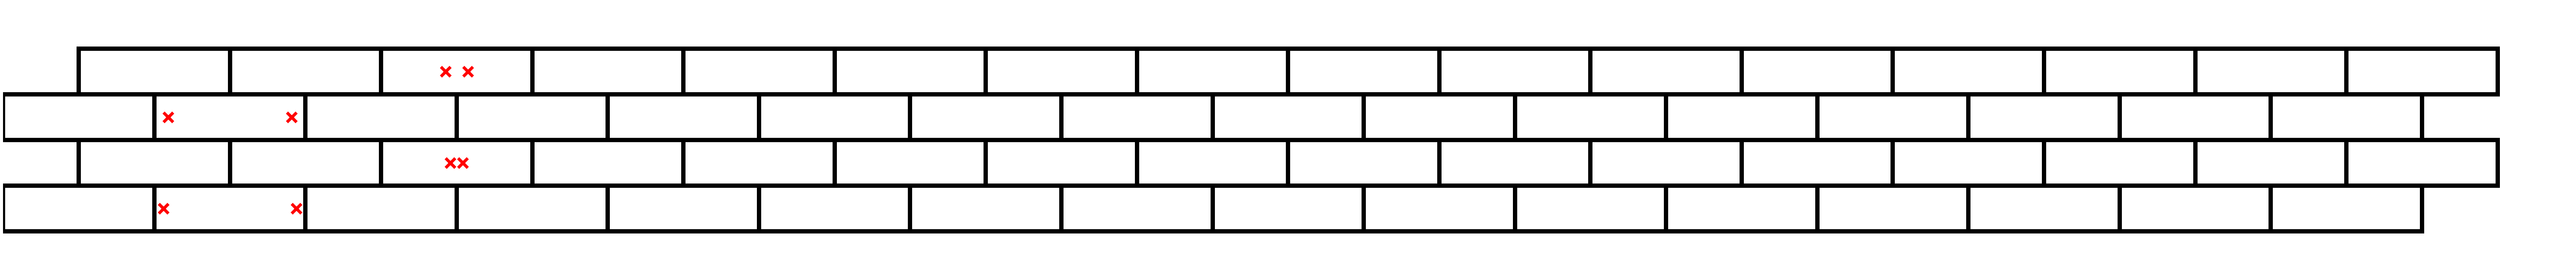

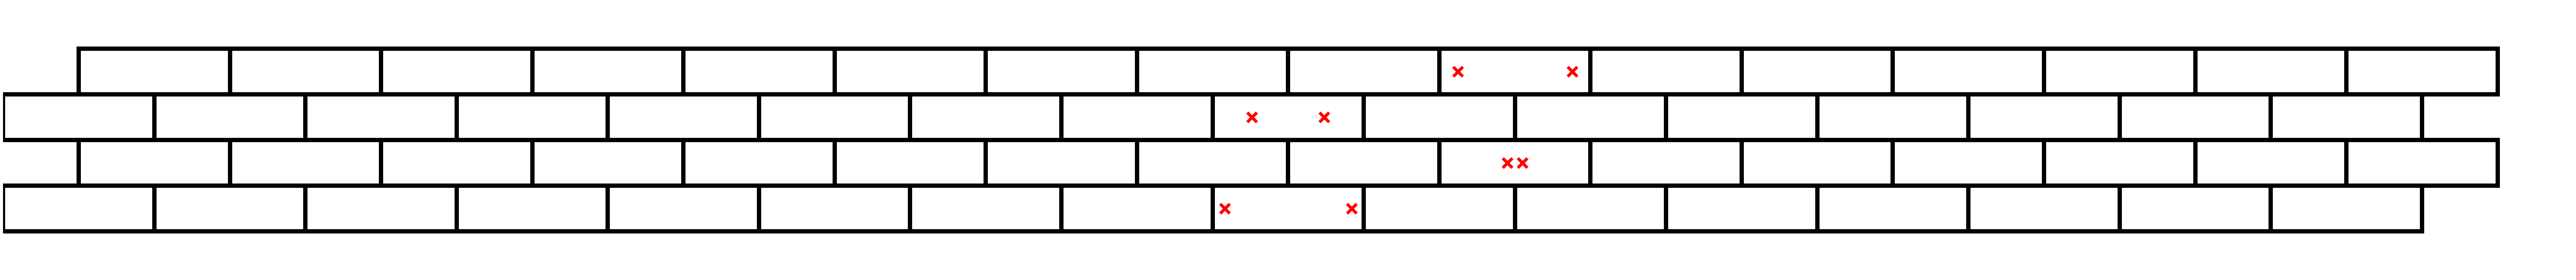

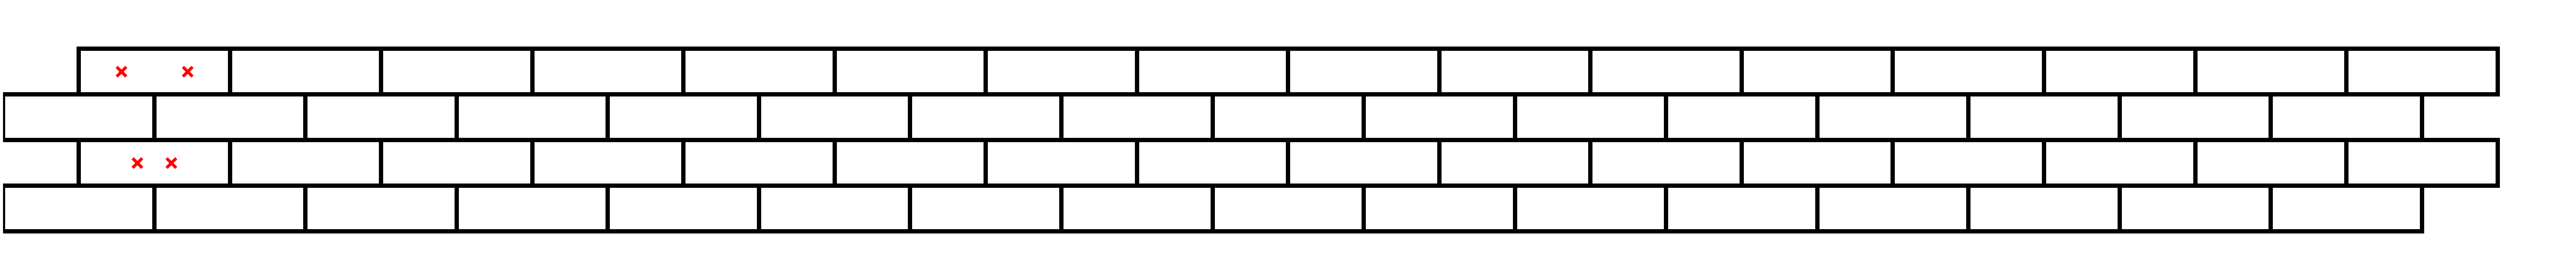

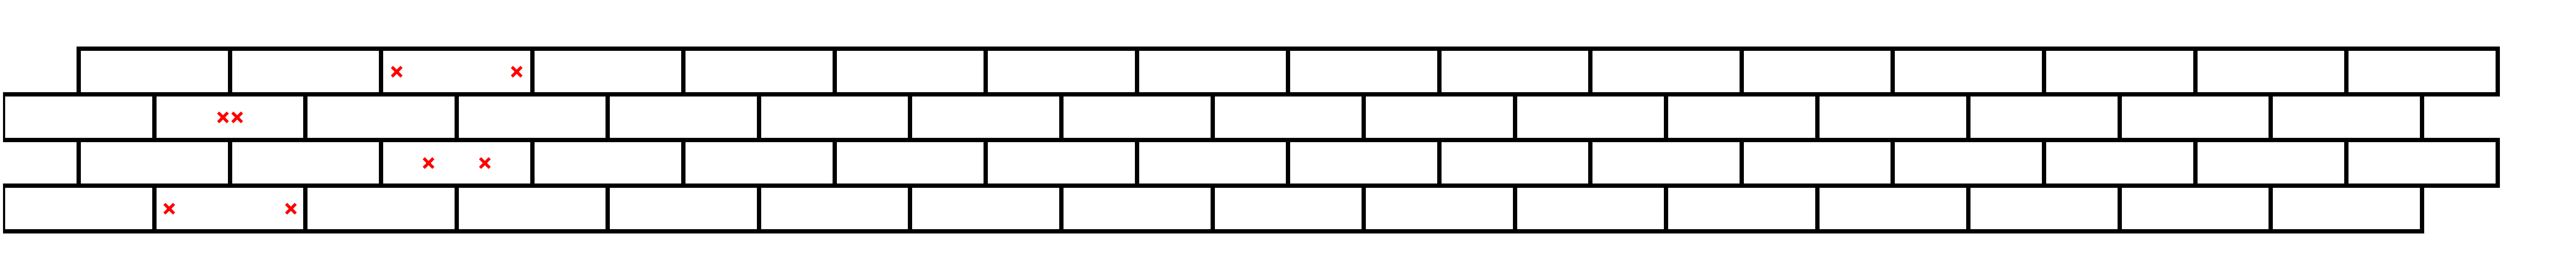

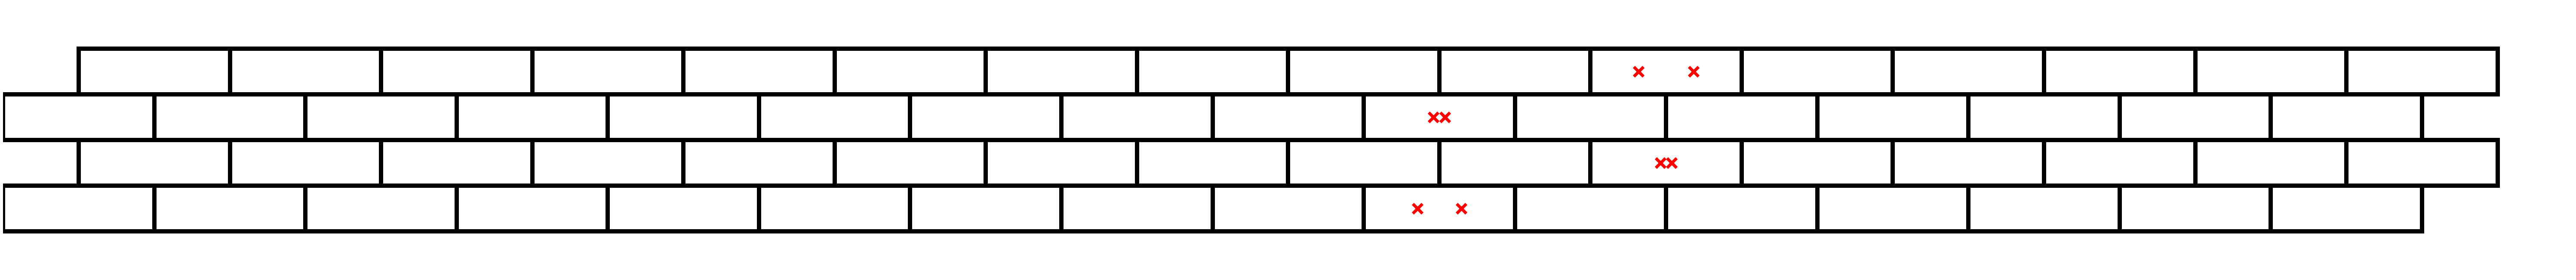

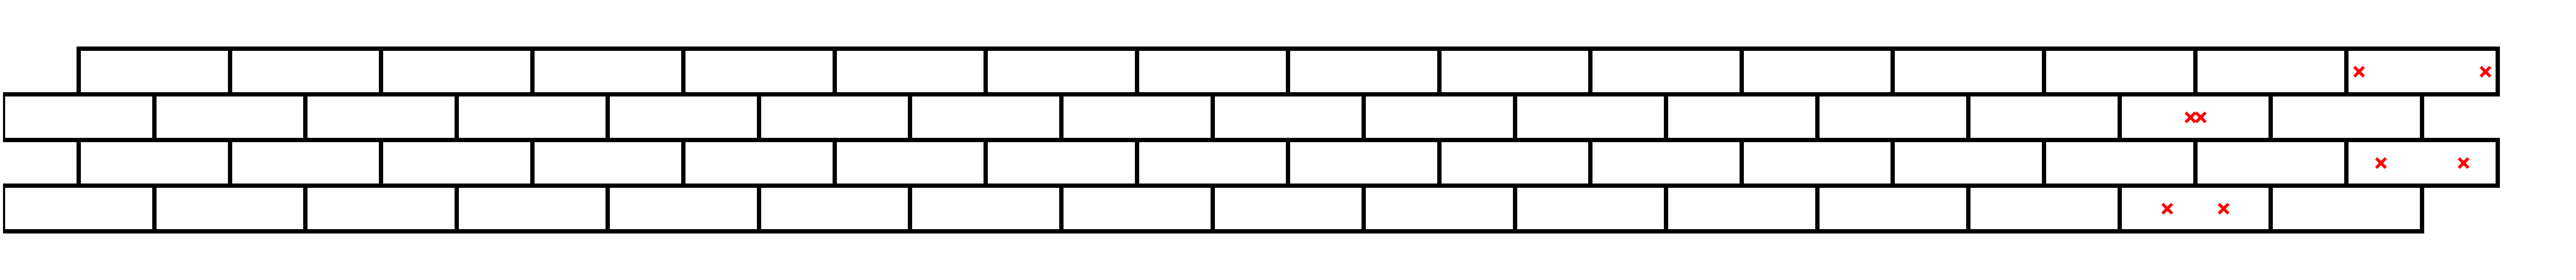

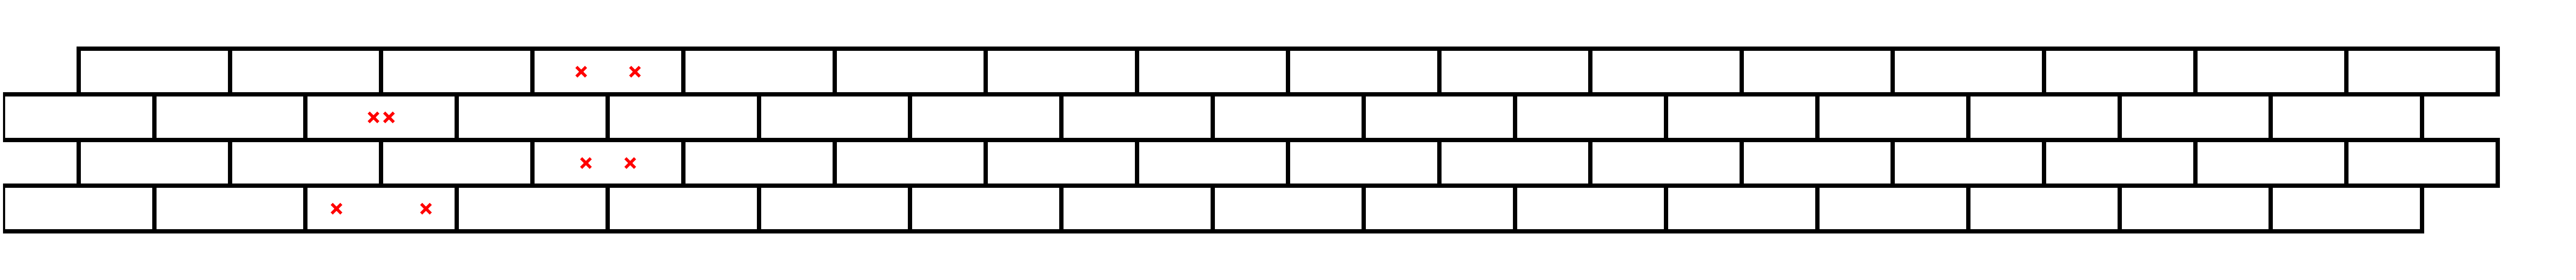

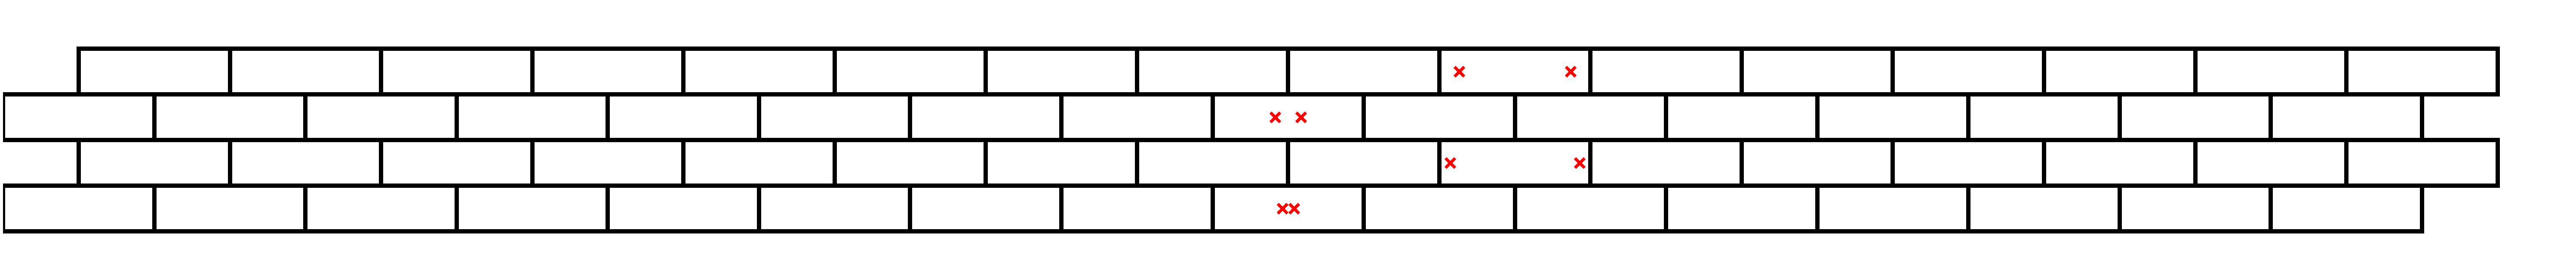

In [20]:
#preso paro paro da Mattia. Nota: dovrebbe essere solido sia all'ordine 0 che 2
#per coerenza con Mattia rinomino le colonne adattandomi alla sua convenzione (se no dovrei modificare la funzione)
df.rename(columns={"HOR_AMBIG_COORD":"X"},inplace=True)

for i in np.unique(df.ORBIT_CNT.values)[:10]:
    try:
        event = df.groupby(['ORBIT_CNT','EVENT']).get_group((i,1))
        event_plot(event)
    except:
        event = df.groupby(['ORBIT_CNT']).get_group(i)
        event_plot(event)

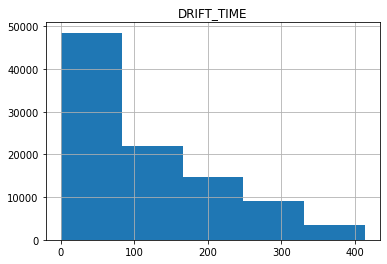

In [17]:
df.hist(column = 'DRIFT_TIME',bins=5);